In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [2]:
from models import CNN

In [3]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [4]:
from visualization import visualize_conv_weights

# Load model and data

In [164]:
cnn = torch.load('output/cnn-mnist-relu-strictening_5.pkl')

In [165]:
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=False,
)

In [166]:
train_loader = Data.DataLoader(dataset=train_data, batch_size=1024, shuffle=True)

In [167]:
batch_x, batch_y = next(iter(train_loader))

In [168]:
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
  )
)

# Capture activations

In [169]:
saved_input = None
saved_activations_conv1 = None
saved_activations_conv2 = None

def store_input(module, input_, output):
    global saved_input
    saved_input, = input_
    saved_input = saved_input.detach().numpy().copy()
    return None

def store_activations_conv1(module, input_, output):
    global saved_activations_conv1
    saved_activations_conv1 = output.detach().numpy().copy()
    return None

def store_activations_conv2(module, input_, output):
    global saved_activations_conv2
    saved_activations_conv2 = output.detach().numpy().copy()
    return None

cnn.conv1.register_forward_hook(store_input)
cnn.conv1[0].register_forward_hook(store_activations_conv1)
cnn.conv2[0].register_forward_hook(store_activations_conv2)
None

In [170]:
cnn(batch_x)

(tensor([[ -5.4463, -10.4424,   0.2436,  ...,  -4.6033,   6.2896,  -1.8518],
         [ -2.2276,  -4.1262,  -0.6244,  ...,  -2.2947,   1.4140,  -0.5454],
         [ -4.2947,  -3.1832,  -4.4947,  ...,  -1.7081,  -2.9889,   1.8042],
         ...,
         [ -6.2789, -11.0895,  -4.5933,  ...,  -3.7551,  -3.8906,  -2.4949],
         [ -8.7003,  -4.8735,  -6.2577,  ...,  -5.6386,   3.0260,  -0.4982],
         [  0.4048,  -4.7443,  -5.0254,  ...,  -8.7514,  -4.0455,  -4.9949]],
        grad_fn=<AddmmBackward>), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ViewBackward>))

In [171]:
saved_input.shape

(1024, 1, 28, 28)

In [172]:
saved_activations_conv1.shape

(1024, 16, 28, 28)

In [173]:
saved_activations_conv2.shape

(1024, 32, 14, 14)

# Inspect activations

In [174]:
conv1_neuron_no = 7

In [175]:
conv1_neuron_weights = cnn.conv1[0].weight[conv1_neuron_no, 0].detach().numpy()

In [176]:
np.std(conv1_neuron_weights.flatten())

0.19263424

In [177]:
np.mean(conv1_neuron_weights.flatten())

0.12273052

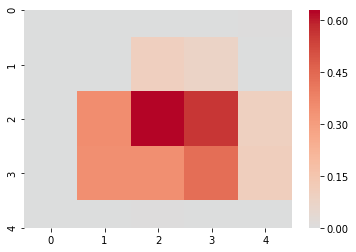

In [178]:
_ = sns.heatmap(conv1_neuron_weights, cmap='coolwarm', center=0)

In [179]:
conv1_neuron_activations = saved_activations_conv1[:,conv1_neuron_no,:,:]

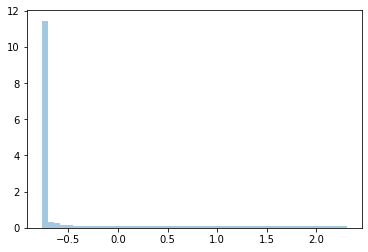

In [180]:
_ = sns.distplot(conv1_neuron_activations.flatten(), norm_hist=True, kde=False)

In [181]:
pd.Series(conv1_neuron_activations.flatten()).describe()

count    802816.000000
mean         -0.364904
std           0.795356
min          -0.765152
25%          -0.764996
50%          -0.764996
75%          -0.524359
max           2.303385
dtype: float64

It is so striking that more than half of the patches lead to the same small activation (around 6% of the maximum activation). Is this a manifestation of a leaking fuzzy logic formula???

In [182]:
top_100_flat_idx = conv1_neuron_activations.flatten().argsort()[-100:]
reconstruct = np.zeros(conv1_neuron_activations.size)
reconstruct[top_100_flat_idx] = 1
reconstruct = reconstruct.reshape(conv1_neuron_activations.shape)
indices = reconstruct.nonzero()

In [183]:
pd.Series(conv1_neuron_activations.flatten()[top_100_flat_idx]).describe()

count    100.000000
mean       2.302271
std        0.000794
min        2.300882
25%        2.301621
50%        2.302292
75%        2.303027
max        2.303385
dtype: float64

In [184]:
def display_patch(indices, k):
    batch_idx, horiz_idx, vert_idx = indices
    b, h, v = batch_idx[k], horiz_idx[k], vert_idx[k]
    plt.imshow(saved_input[b, 0, h-2:h+3, v-2:v+3], cmap='gray')

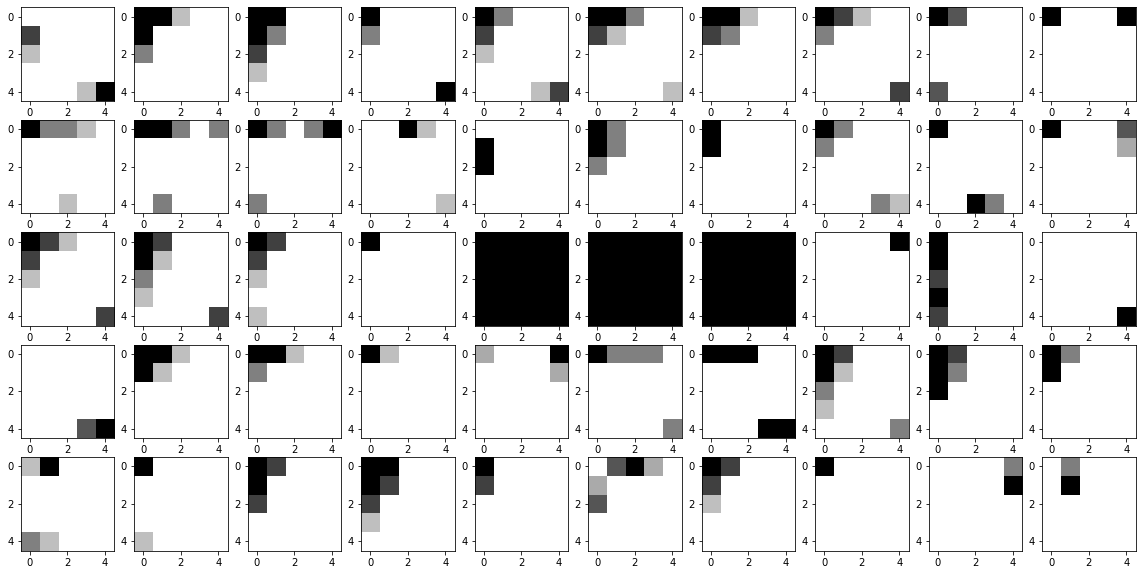

In [185]:
fig=plt.figure(figsize=(20, 10))
columns = 10
rows = 5
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    display_patch(indices, i-1)

In [186]:
def display_patch_in_context(indices, k):
    batch_idx, horiz_idx, vert_idx = indices
    fig=plt.figure(figsize=(8, 4))

    fig.add_subplot(1, 2, 1)
    b, h, v = batch_idx[k], horiz_idx[k], vert_idx[k]
    plt.imshow(saved_input[b, 0], cmap='gray')
    
    fig.add_subplot(1, 2, 2)
    img_new = np.zeros_like(saved_input[b, 0])
    img_new[h-2:h+3, v-2:v+3] = saved_input[b, 0, h-2:h+3, v-2:v+3]
    plt.imshow(img_new, cmap='gray')

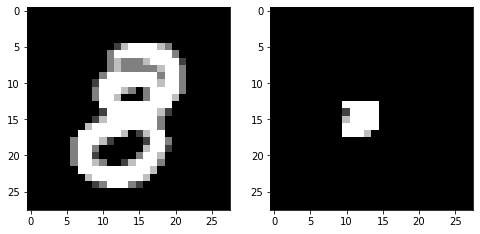

In [187]:
display_patch_in_context(indices, 0)

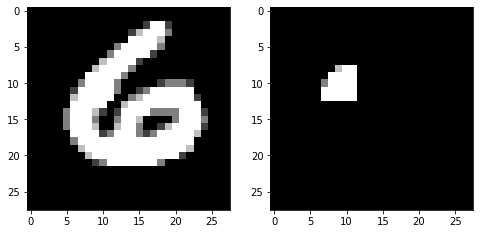

In [188]:
display_patch_in_context(indices, 1)

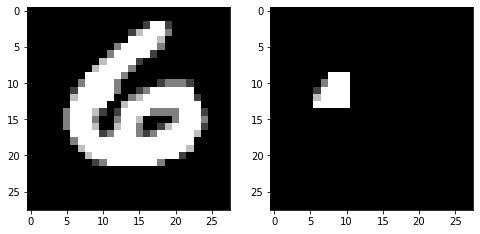

In [189]:
display_patch_in_context(indices, 2)

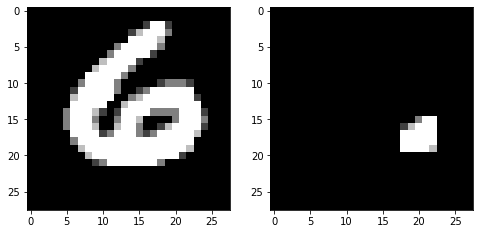

In [190]:
display_patch_in_context(indices, 5)

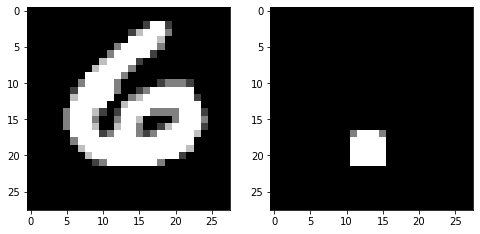

In [191]:
display_patch_in_context(indices, 9)

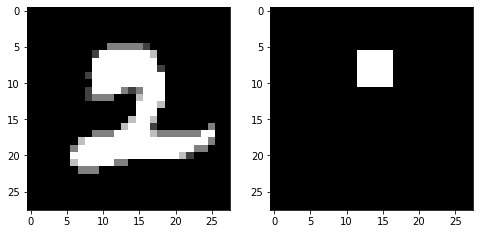

In [192]:
display_patch_in_context(indices, 26)

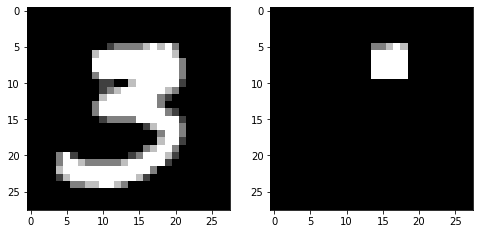

In [193]:
display_patch_in_context(indices, 80)

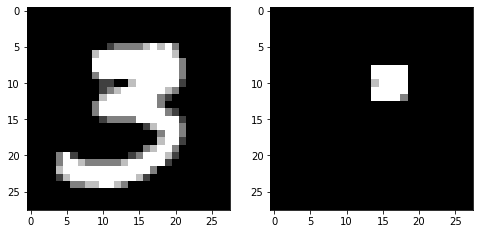

In [194]:
display_patch_in_context(indices, 90)

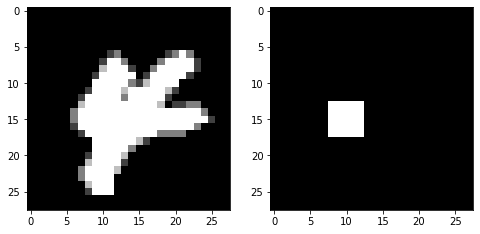

In [195]:
display_patch_in_context(indices, 60)

# Analyze activation patterns by clustering

In [196]:
q99 = np.quantile(conv1_neuron_activations.flatten(), 0.99)
q99_indices = (conv1_neuron_activations > q99).nonzero()

In [197]:
q99

2.182726120948791

In [198]:
len(q99_indices[0])

8029

In [199]:
saved_input_padded = np.zeros((saved_input.shape[0], saved_input.shape[1],
                               saved_input.shape[2]+4, saved_input.shape[3]+4))
saved_input_padded[:,:,2:-2, 2:-2] = saved_input

In [200]:
saved_input_padded.shape

(1024, 1, 32, 32)

In [201]:
saved_input.shape

(1024, 1, 28, 28)

In [202]:
def extract_patch(indices, k):
    batch_idx, horiz_idx, vert_idx = indices
    b, h, v = batch_idx[k], horiz_idx[k], vert_idx[k]
    h += 2 # index in padded image
    v += 2 # index in padded image
    patch = saved_input_padded[b, 0, h-2:h+3, v-2:v+3].flatten()
    if len(patch) != 25:
        print(b, h, v)
        raise "Wrong size!"
    return patch

In [203]:
patches = np.vstack([extract_patch(q99_indices, k) for k in range(len(q99_indices[0]))])

In [204]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(patches)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [205]:
cluster0_indices, = (kmeans.labels_ == 0).nonzero()
cluster1_indices, = (kmeans.labels_ == 1).nonzero()
cluster2_indices, = (kmeans.labels_ == 2).nonzero()

In [206]:
def display_cluster(cluster_indices):
    fig=plt.figure(figsize=(20, 10))
    rows, columns = 5, 10
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        display_patch(q99_indices, cluster_indices[i-1])

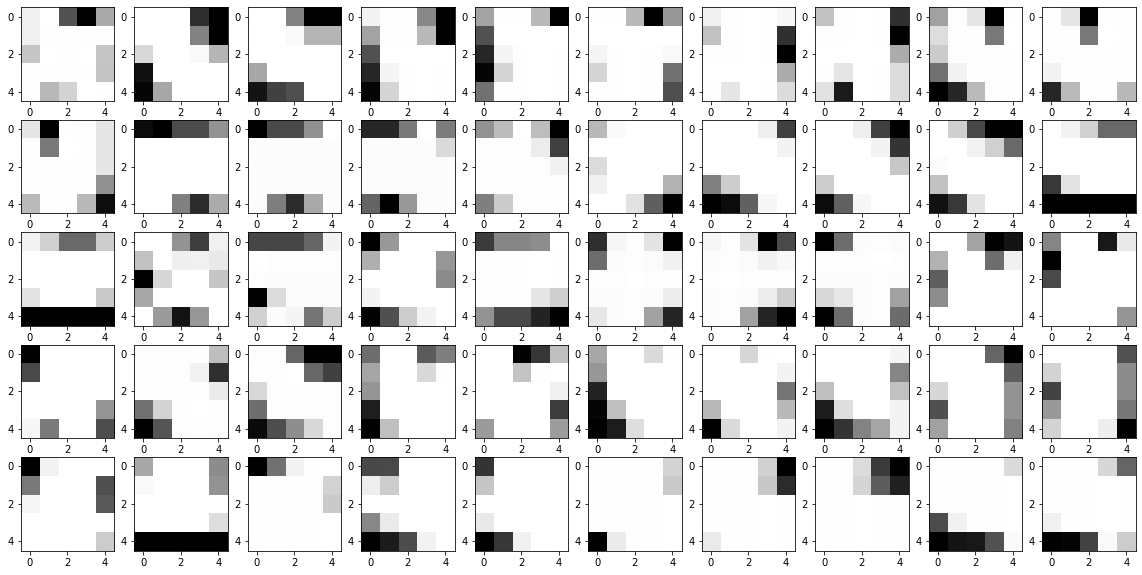

In [207]:
display_cluster(cluster0_indices)

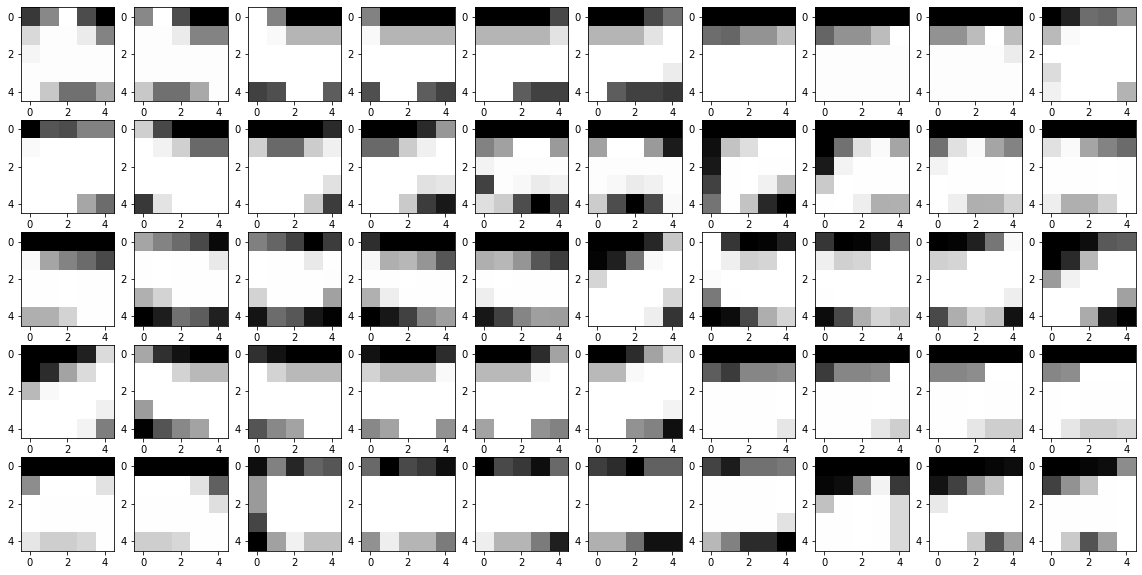

In [208]:
display_cluster(cluster1_indices)

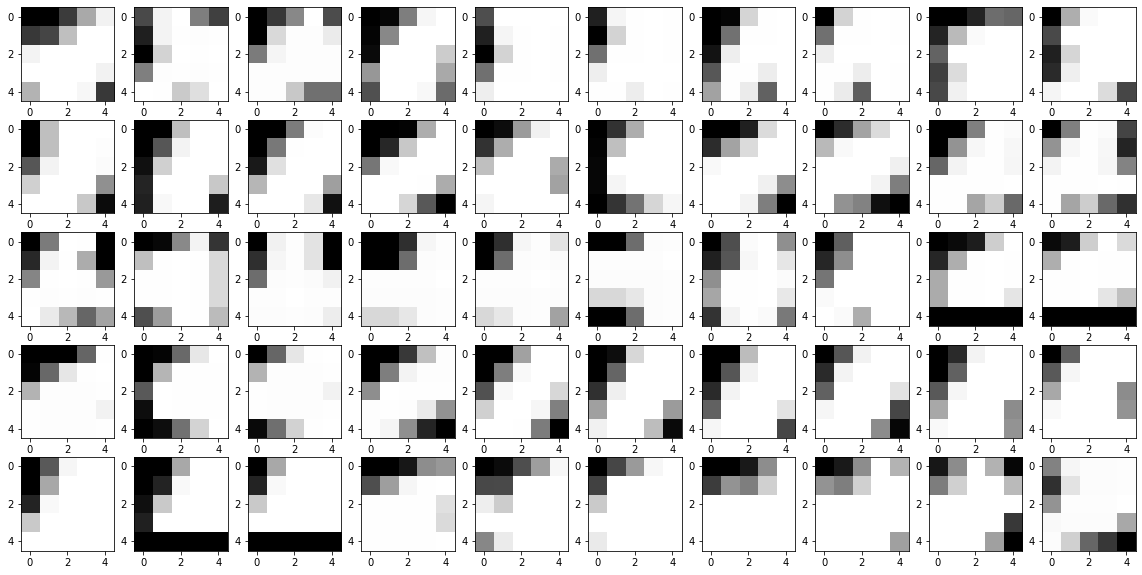

In [209]:
display_cluster(cluster2_indices)

# Look at all neurons

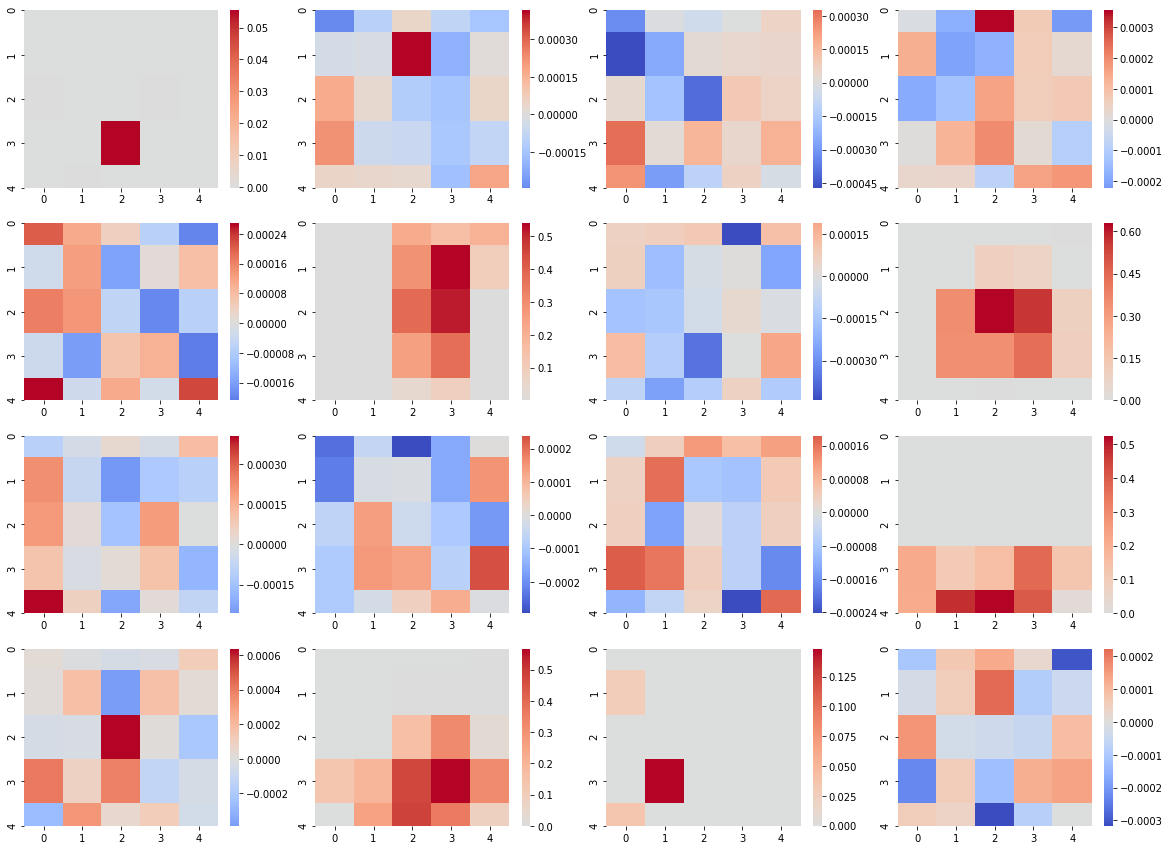

In [210]:
visualize_conv_weights(cnn.conv1[0])

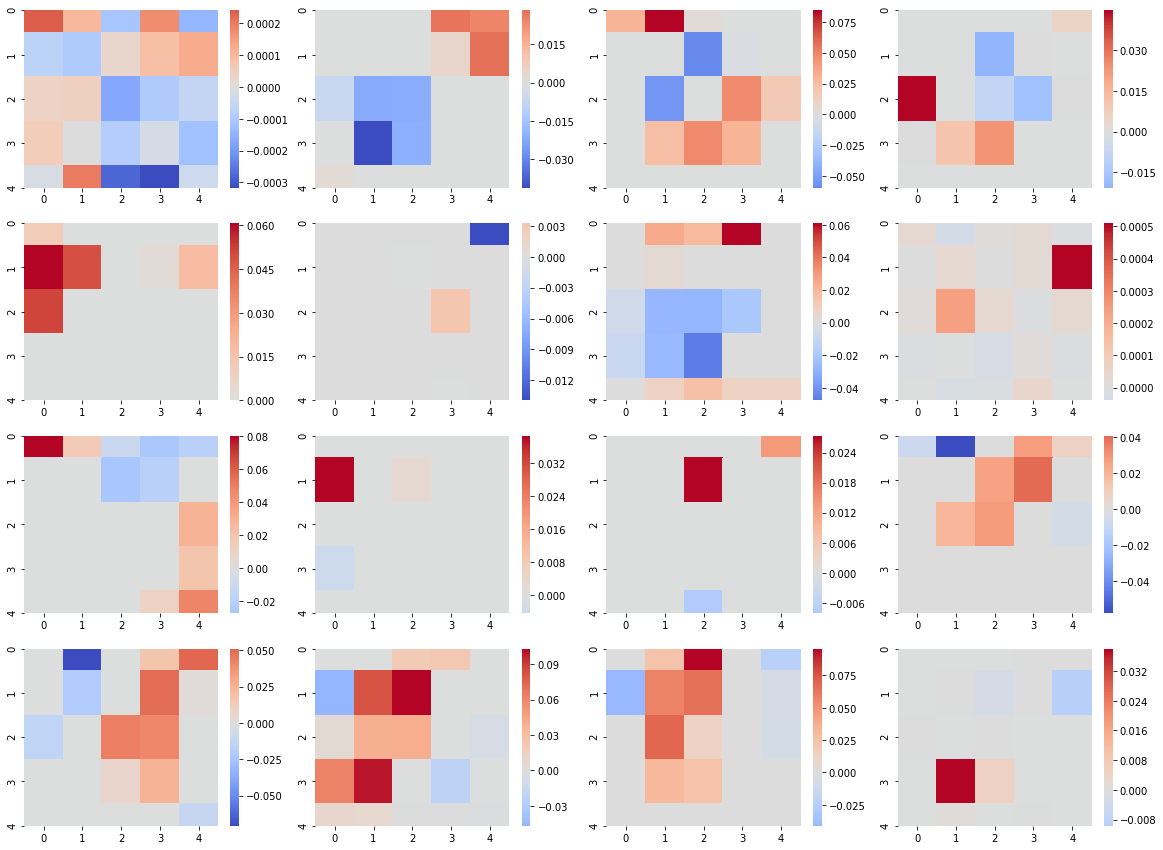

In [211]:
visualize_conv_weights(cnn.conv2[0], channel=0)

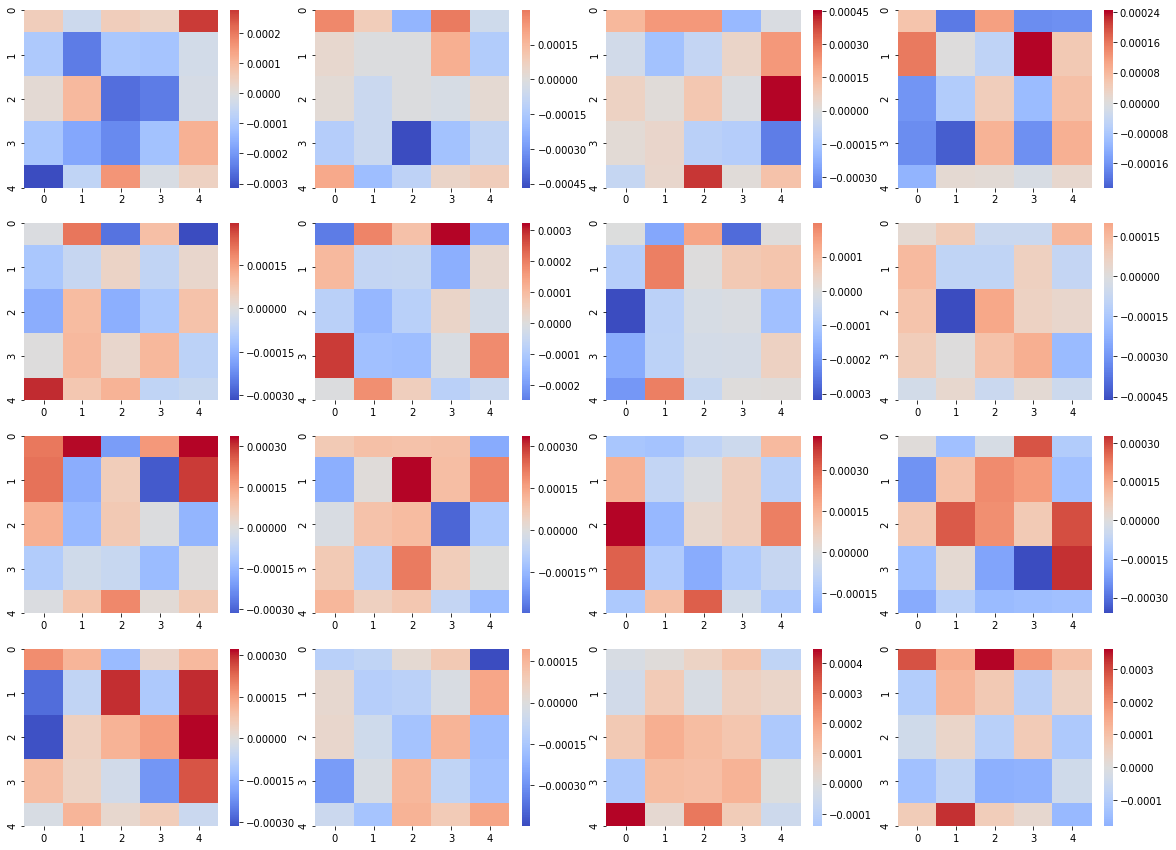

In [212]:
visualize_conv_weights(cnn.conv2[0], channel=1)

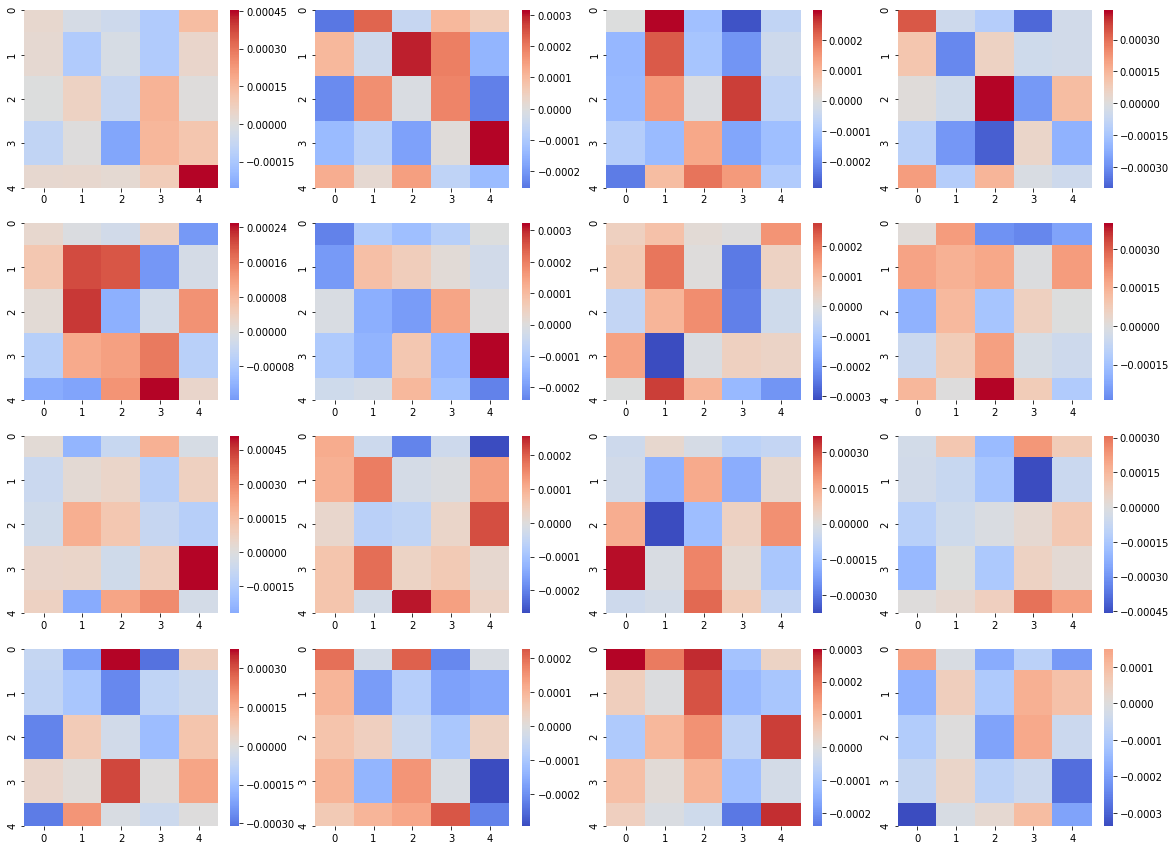

In [213]:
visualize_conv_weights(cnn.conv2[0], channel=2)

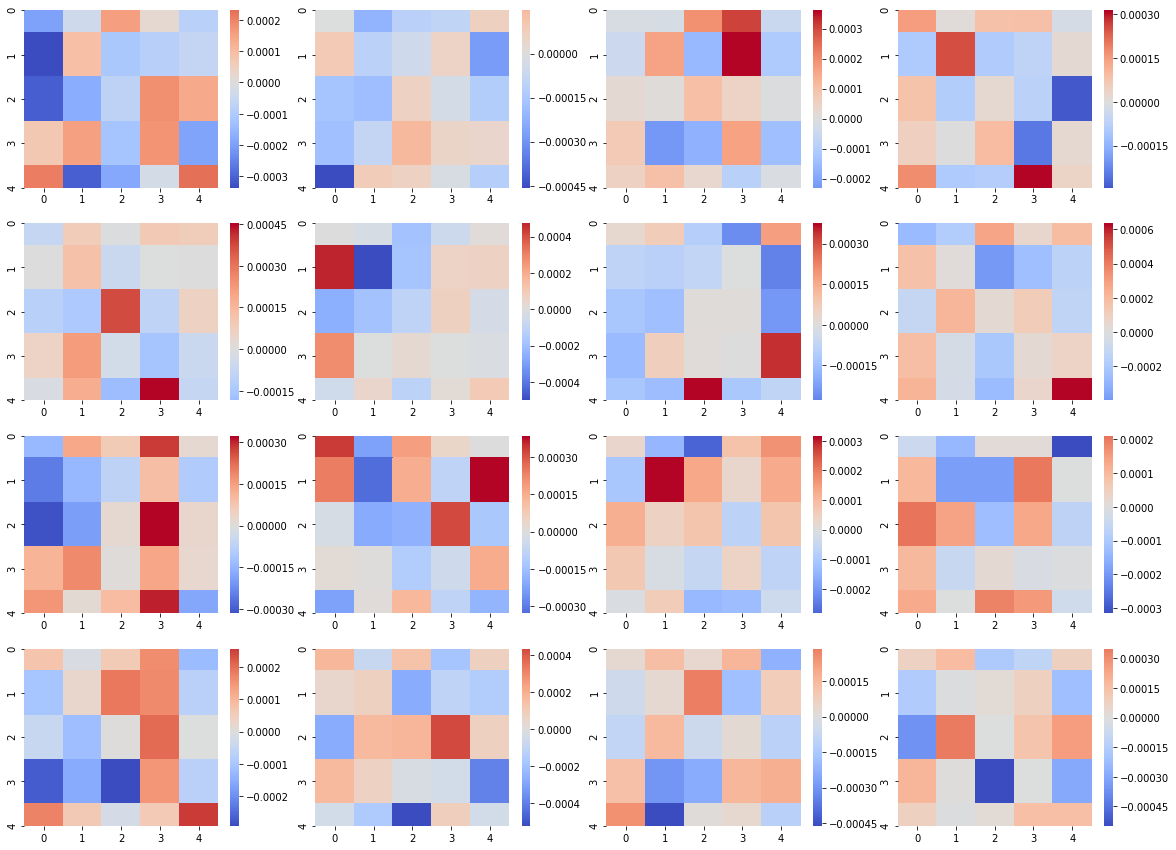

In [214]:
visualize_conv_weights(cnn.conv2[0], channel=3)

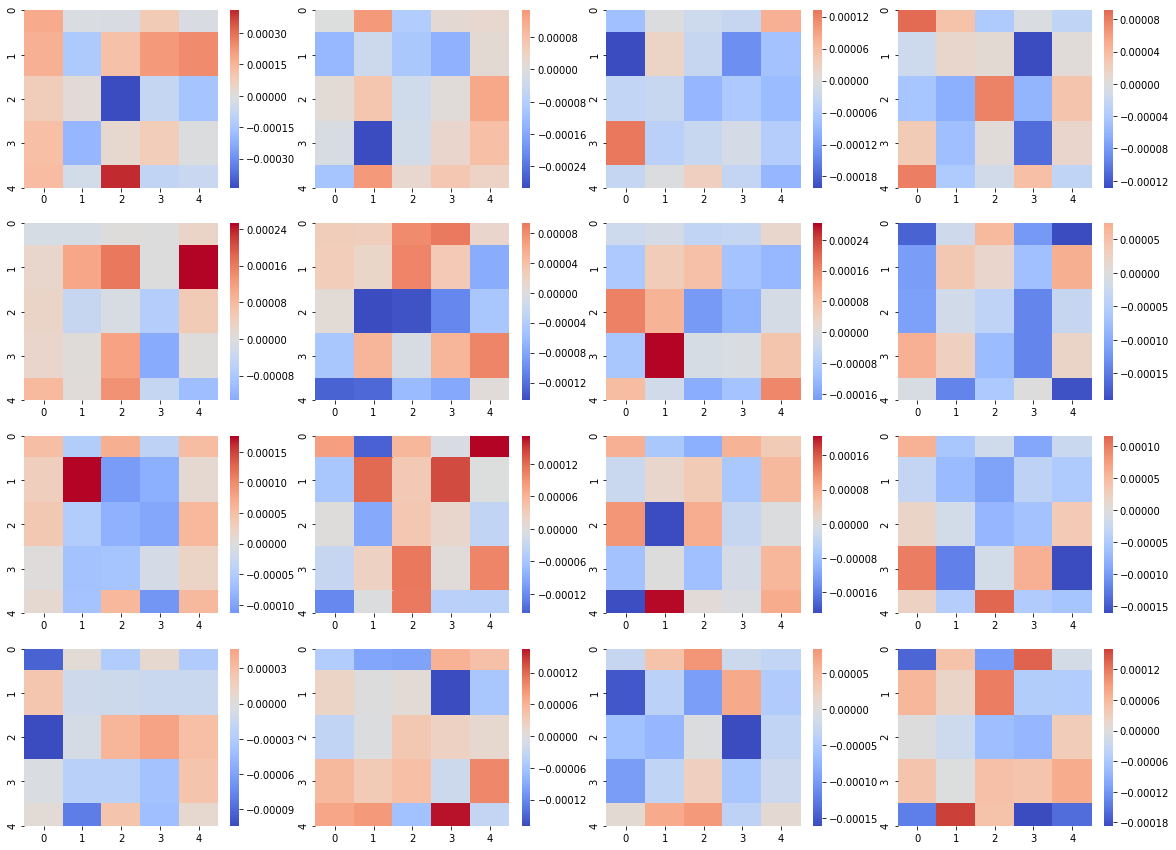

In [215]:
visualize_conv_weights(cnn.conv2[0], channel=4)